# Objective

The Head of Schools is interested in examining the following key questions:

1. Determine the percentage of students At Benchmark or Above Benchmark by grade and teacher
   - Is there a specific grade level that needs more support?
   - Is there a correlation between certain teachers and the likelihood of students being At or Above Benchmark?
   

2. Are there any trends between general education students and students receiving special education services?

3. Does poor attendance or chronic absenteeism (missing 10% or more of school days) impact students’ STAR performance?

4. What next steps would you take to help develop a strategy for improving regional performance?

In [4]:
# importing packages
import pandas as pd
import string as str
import matplotlib.pyplot as plt

star = pd.read_csv(r'/Users/scipio/Documents/KIPP Performance Task/Manager of Data & Analytics_Performance Task_STAR Table - STAR.csv')
att = pd.read_csv(r'/Users/scipio/Documents/KIPP Performance Task/Performance Task_ Attendance Table - Attendance.csv')

In [5]:
# Data Cleaing
star = star[star['Teacher_Name'].notna()] # <- filtering out null values
star = star[star['Test_Type'].notna()] # <- filtering out null values
star['Test_Type'] = star['Test_Type'].replace('Star Math Enterprise Tests','Math') 
star['Test_Type'] = star['Test_Type'].replace('Star Reading Enterprise Tests','Reading')
star = star[star['Percentile_Rank'].notna()] # <- filtering out null values
star['Teacher_Name'] = star['Teacher_Name'].str.replace('Teacher','') # <- replacing 'teacher'
star['Teacher_Name'] = star['Teacher_Name'].astype('int') # <- casting as an int for statistical analysis

att = att[att['Status']=='Active'] # returing all active students
att = att[['Student_Number','Membership','Absent', 'Special_Education_Program']]

## Data Quality Notes

There were null values in several columns in the dataset. The null values were filtered out and relevant values were retaomed. The columns that were filtered are listed below:

- Teacher_Name
- Test_Type
- Percentile_Rank

Additionally, all students with a status of '**Active**' were filtered in the dataset to return only active students in the attendance table.


In [6]:
# Merging Datasets on each table's unique identifier
t1 = star.merge(att, left_on = 'Student_ID', right_on = 'Student_Number', how = 'left')
t1.shape

(7338, 14)

### 1. Determine the percentage of students At Benchmark or Above Benchmark by grade and teacher
  - Is there a specific grade level that needs more support?
  - Is there a correlation between certain teachers and the likelihood of students being At or Above Benchmark?

In [7]:
# Overall Proficiency
def ovr_prof (x):
    if x >= 40.0: # <- At or Above Benchmark
        return 1
    else:
        return 0
    
t1['Overall_Proficiency'] = t1['Percentile_Rank'].apply(lambda x:ovr_prof (x))

In [8]:
# Intervention Metric
def Intervention (x):
    if x < 25: # < - Percentile Rank < 25 requires intervention
        return 1
    else:
        return 0 
t1['Intervention Metric'] = t1['Percentile_Rank'].apply(lambda x:Intervention (x))

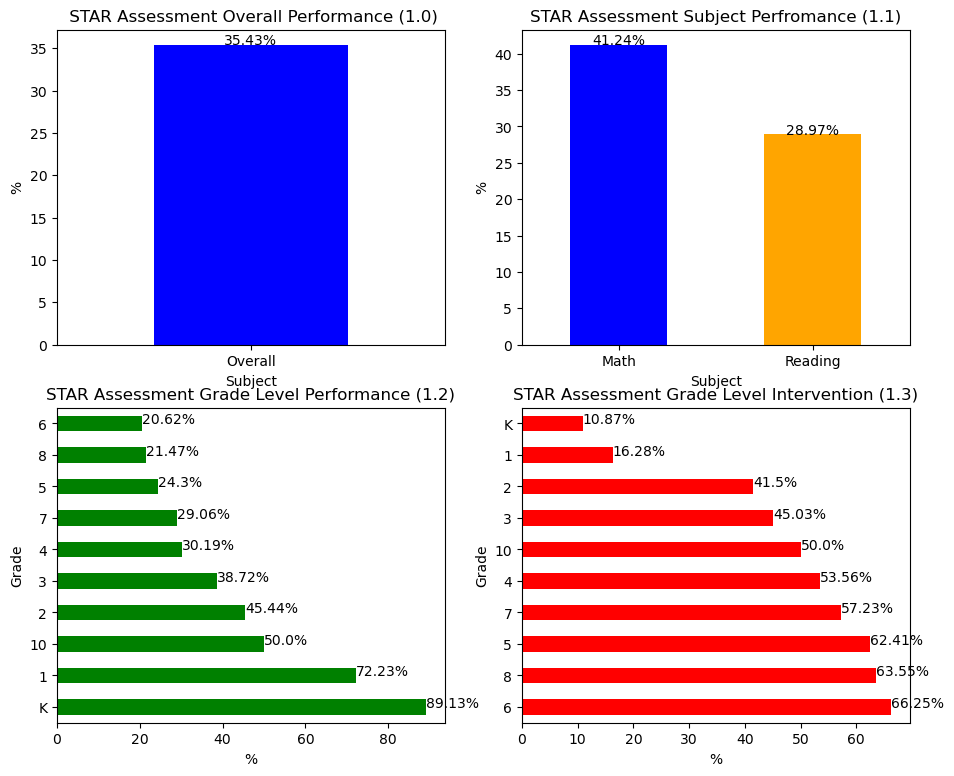

In [9]:
# Plotting At or Above Benchmark Metrics
fig,ax = plt.subplots(nrows = 2, ncols =2, figsize = (11,9)) # <- subplot

color = ['blue', 'orange'] # < - color variable

# Overall At or Above Benchmark Metrics
Overall_Proficiency = t1['Overall_Proficiency'].mean() # 
data = {'Overall STAR Performance':[Overall_Proficiency]}
Overall = pd.DataFrame(data).reset_index()
Overall.rename(columns = {'index':'Subject'}, inplace = True)
Overall['Subject'] = Overall['Subject'].replace(0,'Overall')
Overall['Overall STAR Performance'] = round(Overall['Overall STAR Performance'] * 100,2)


# At or Above Benchmark by Subject
subject = t1.groupby('Test_Type')['Overall_Proficiency'].mean().reset_index()
subject.rename(columns = {'Test_Type':'Subject'}, inplace = True)
subject['Overall_Proficiency'] = round(subject['Overall_Proficiency'] * 100,2)


# At or Above Benchmark by Grade
grade = t1.groupby('Current_Grade')['Overall_Proficiency'].mean().reset_index().sort_values(by='Overall_Proficiency',ascending = False)
grade['Overall_Proficiency'] = round(grade['Overall_Proficiency'] * 100,2)
grade.rename(columns = {'Current_Grade':'Grade'}, inplace = True)

# Intervention Metric by Grade
grade_intervention = t1.groupby('Current_Grade')['Intervention Metric'].mean().reset_index().sort_values(by = 'Intervention Metric', ascending = False)
grade_intervention['Intervention Metric']= round(grade_intervention['Intervention Metric'] * 100,2)
grade_intervention.rename(columns = {'Current_Grade':'Grade'}, inplace = True)


#Plotting Data
Overall.plot(kind = 'bar', ax = ax[0,0],rot = 0,x = 'Subject',ylabel = '%',title = ' STAR Assessment Overall Performance (1.0)', color = 'blue', legend = False)
subject.plot(kind = 'bar', ax = ax[0,1],rot = 0,x = 'Subject',ylabel = '%', y = 'Overall_Proficiency', title = 'STAR Assessment Subject Perfromance (1.1)', color = color, legend = False)
grade.plot(kind = 'barh', ax = ax[1,0], rot = 0,x = 'Grade',xlabel = '%',title= 'STAR Assessment Grade Level Performance (1.2)' , color = 'green', legend = False)
grade_intervention.plot(kind = 'barh', ax = ax[1,1], rot = 0, x = 'Grade',xlabel = '%', title = 'STAR Assessment Grade Level Intervention (1.3)', color = 'red', legend = False)


#Labels
for i,v in enumerate(Overall['Overall STAR Performance']):
    ax[0,0].text(i,v,f"{v}%", ha = 'center')
    
for i,v in enumerate(subject['Overall_Proficiency']):
    ax[0,1].text(i,v,f"{v}%", ha = 'center')
    
for i,v in enumerate(grade['Overall_Proficiency']):
    ax[1,0].text(v,i,f"{v}%")
    
    
for i,v in enumerate(grade_intervention['Intervention Metric']):
    ax[1,1].text(v,i,f"{v}%")
    
plt.show()

Overall, approximately 35% **(figure 1.0)** of students scored at or above benchmark on their STAR Assessments, approximately 29% on Reading and approximately 41% on Math **(figure 1.1)**. Grades K and 1 had the highest overall proficiency approximately 89% and 72% respectively **(figure 1.2)**. Grades 4-8 need more support **(figure 1.3)** as the majority of their students fall below the 24th percentile, indicative of a student needing intervention.

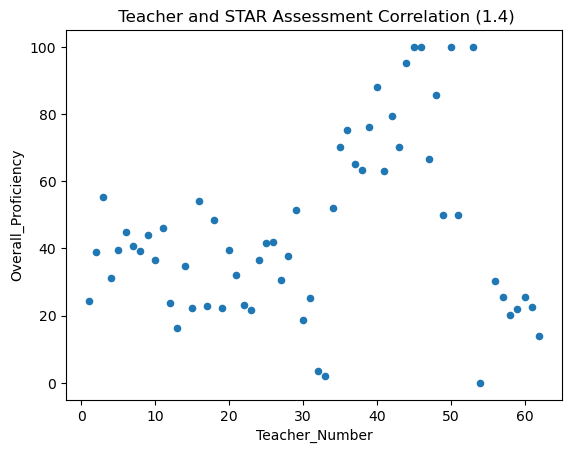

In [10]:
# Teacher Correlation and STAR Assessment Results
Teacher_Corr = round(t1.groupby('Teacher_Name')['Overall_Proficiency'].mean() * 100,2).reset_index().sort_values(by = 'Overall_Proficiency', ascending = False )
Teacher_Corr.rename(columns = {'Teacher_Name':'Teacher_Number'}, inplace = True)
Teacher_Corr.plot(kind = 'scatter', x = 'Teacher_Number', y = 'Overall_Proficiency', title = ' Teacher and STAR Assessment Correlation (1.4)')
plt.show()

In [11]:
#Correlation Coefficienct
print(Teacher_Corr.corr())

                     Teacher_Number  Overall_Proficiency
Teacher_Number              1.00000              0.22754
Overall_Proficiency         0.22754              1.00000


Based on the scatter plot above **(figure 1.4)** and the correlation coefficient there is a weak positive correlation between teachers’ and student performance as there was a positive correlation coefficient when comparing teachers and STAR Assessment results.

### 2. Are there any trends between general education students and students receiving special education services?

In [12]:
# General Education v. Special Services Comparison

"""
0 - General Education
1- Special Education
"""

Student_Population = round(t1.groupby('Special_Education_Program')['Overall_Proficiency'].mean() * 100,2).reset_index()
Student_Population.rename(columns = {'Special_Education_Program':'Student_Population'}, inplace = True)
Student_Population['Student_Population'] = Student_Population['Student_Population'].replace(0,'General Education')
Student_Population['Student_Population'] = Student_Population['Student_Population'].replace(1, 'Services')

In [13]:
# General Education v. Special Services Comparison Subject Comparison
Student_Population_Subject = round(t1.groupby(['Special_Education_Program','Test_Type'])['Overall_Proficiency'].mean() * 100,2).reset_index()
Student_Population_Subject.rename(columns = {'Special_Education_Program':'Student_Population'}, inplace = True)
Student_Population_Subject.rename(columns = {'Test_Type':'Subject'}, inplace = True)
Student_Population_Subject['Student_Population'] = Student_Population_Subject['Student_Population'].replace(0,'General Education')
Student_Population_Subject['Student_Population'] = Student_Population_Subject['Student_Population'].replace(1, 'Services')
Student_Population_Subject = Student_Population_Subject.sort_values(by = 'Subject')

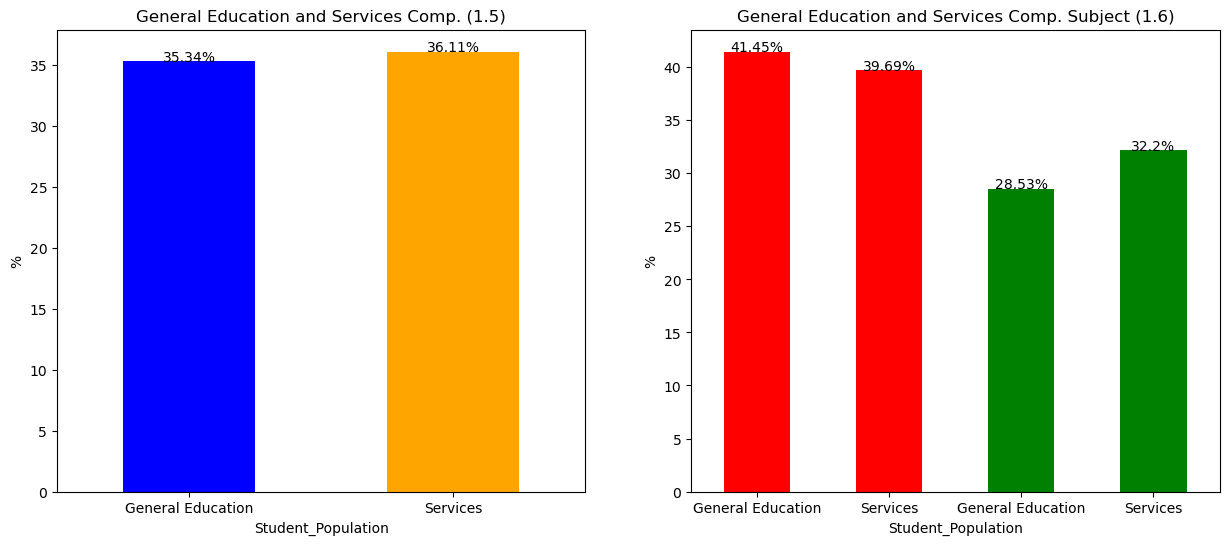

In [14]:
# Plotting General Education v Services Data
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (15,6))

color1 = ['blue','orange']# <- color variable
color2 = ['red', 'red','green', 'green'] # < - color variable

# Plotting data
Student_Population.plot(kind = 'bar', x = 'Student_Population', y = 'Overall_Proficiency',rot = 0,title = 'General Education and Services Comp. (1.5)', ylabel = '%',ax = ax[0], legend = False, color = color1)
Student_Population_Subject.plot(kind = 'bar', x = 'Student_Population',y = 'Overall_Proficiency',rot = 0, title = 'General Education and Services Comp. Subject (1.6)', ylabel = '%',ax = ax[1], legend = False,color = color2)

# Labels

for i,v in enumerate (Student_Population['Overall_Proficiency']):
    ax[0].text(i,v,f"{v}%", ha= 'center')
    
for i,v in enumerate (Student_Population_Subject['Overall_Proficiency']):
    ax[1].text(i,v,f"{v}%", ha= 'center')

plt.show()

There is very little difference in the overall student performance when comparing general education students to students who receive services. Approximately 35% of general education students performed at or above benchmark compared to approximately 36% of students who receive services performing at or above benchmark **(figure 1.5)**. It is also worthy to note that students receiving services outperformed their general education peers in all grade levels with the exception of 1st and 5th grade. Additionally, approximately 32% of students who receive services scored at benchmark or higher on the Reading portion of the STAR Assessment compared to 29% of students in general education, a 3% difference **(figure 1.6)**.Lastly, general education students outperformed students who received services on the Math portion on the STAR Assessment, approximately 41% to 40% respectively.

### 3. Does poor attendance or chronic absenteeism (missing 10% or more of school days) impact students’ STAR performance?

In [15]:
# Chronically Absent v. Not Chronically Absent
t1['Abs Pct'] = round(t1['Absent']/t1['Membership'],2)

def chronically_abs (x):
    if x >= .10:
        return 'Yes'
    else:
        return 'No'

t1['Chronically Absent'] = t1['Abs Pct'].apply(lambda x:chronically_abs (x))


Attendance_Comp = round(t1.groupby('Chronically Absent')['Overall_Proficiency'].mean().reset_index().sort_values(by = 'Overall_Proficiency'),2)

Attendance_Comp['Diff'] = round(Attendance_Comp['Overall_Proficiency'].diff().fillna(0),2)
Attendance_Comp['Pct Diff'] = round(Attendance_Comp['Overall_Proficiency'].pct_change().fillna(0),2)
Attendance_Comp['Overall_Proficiency'] = round(Attendance_Comp['Overall_Proficiency'] * 100,2)
Attendance_Comp['Diff'] = round(Attendance_Comp['Diff'] * 100,2)
Attendance_Comp['Pct Diff'] = round(Attendance_Comp['Pct Diff'] * 100,2)

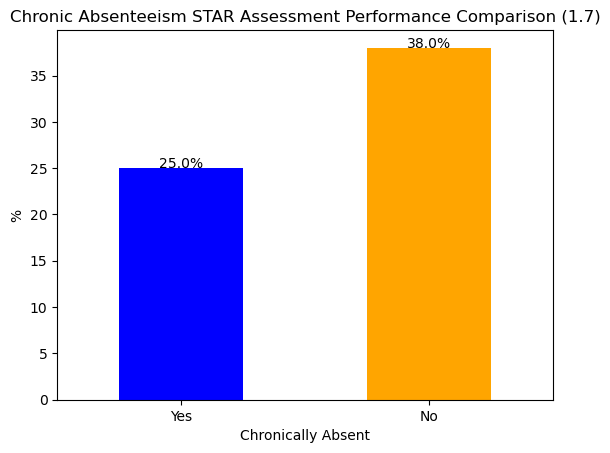

In [16]:
# Plotting Chronic Absenteeism STAR Assessment Data
Attendance_Comp.plot(kind = 'bar', x = 'Chronically Absent', y = 'Overall_Proficiency', ylabel = '%', rot = 0, color = ['blue','orange'], legend = False, title = 'Chronic Absenteeism STAR Assessment Performance Comparison (1.7)')

# Data Labels
for i,v in enumerate(Attendance_Comp['Overall_Proficiency']):
    plt.text(i,v,f"{v}%", ha = 'center')
    
plt.show()

Yes, poor attendance impacted students’ performance on the STAR Assessment. Students that were not chronically absent scored 150% higher on the STAR Assessment than students who were chronically absent. Approximately 25% of students that were considered to be chronically absent scored at or above benchmark compared to approximately 38% of students who were not chronically absent **(figure 1.7)**.

### 4. What next steps would you take to help develop a strategy for improving regional performance?

The next step would involve meeting with academic leadership sharing my findings and providing recommendations and a plan for implementation as well as to track progress on an agreed time frame to prepare for the next STAR Assessment. I’d make the following recommendations:

- Address chronic absenteeism.
- Leverage pedagogy of high performing teachers and departments, e.g. SPED.
- Address Reading STAR Assessment performance gap.
- Differentiation in classrooms to address students that scored below the 25th percentile.
- Focus on moving students that are in the On Watch/At Risk range into the At Benchmark or Above Benchmark ranges.

### Data Repository

- Access the data repository **[HERE](https://github.com/Scipio94/STAR--Assessment-Analysis)**